# Generative AI Application (Worked Example):
## Image-based Search (OpenAI CLIP, Pinecone (Vector Database))
-Divyesh Singh Rajput


## Introduction

The fashion industry stands at the brink of a technological revolution driven by AI. Its intricacies, including diverse catalogs and specialized customer datasets, pose a unique challenge for the development of universally adaptable solutions.

Imagine two data scientists, Mary and Luis, at a prominent fashion company. They navigate a dynamic landscape that demands continuous attention:

- **Mary** focuses on crafting a classification tool to streamline product categorization. Her system identifies products and assigns them to specific categories, such as shoes or dresses.
- **Luis** aims to enhance the shopping experience by improving product matching. His tool interprets customer queries in multiple languages, like "a red dress," and suggests relevant products.

Each new AI model introduced into the system brings along complex lifecycle challenges and intricate dependencies:

- Mary's classification model necessitates regular updates to keep pace with the expanding inventory and evolving categories.
- Luis's matching model heavily relies on the accuracy of product metadata.

Despite working for the same company, Mary and Luis tackle distinct challenges with disparate models.

But what if there's a more cohesive approach?

Today, we're thrilled to explore a novel direction – the development of a universal model for fashion-related data. We introduce a customized version of OpenAI's CLIP, finely tuned for fashion data, aptly named CLIP. Our latest research paper, elaborating on this breakthrough, has been published in Nature Scientific Reports.


## Understanding CLIP

CLIP stands for Contrastive Language-Image Pre-training. It represents a neural network trained on a diverse set of image and text pairs. The core concept behind CLIP is the establishment of a unified embedding space for both images and text. This means that CLIP enables tasks such as retrieving the most pertinent caption for a given image from a set of captions, or conversely, identifying the most relevant image corresponding to a given text snippet.

It's essential to emphasize that CLIP does not operate as a generative model. In other words, it doesn't directly generate text snippets or images. Instead, it leverages the embedding space to retrieve items that have been previously embedded.

CLIP's versatility extends beyond simple captioning tasks. Its shared embedding space allows for various applications, including image and text retrieval, recommendation systems, and even cross-modal understanding. By learning meaningful representations of both images and text, CLIP enables efficient and nuanced analysis and interaction between the two modalities.


In [1]:
# We need 'transformers' for accessing the CLIP model, 'torch' for tensor operations, and 'Pinecone' for the vector database.
!pip install transformers torch pinecone-client pillow

## CLIP Model and Processor


- **Model**: The CLIP model is well-known, but what's intriguing is that it's actually composed of two models. CLIP utilizes a ViT-like transformer for visual features and a causal language model for text features. This class integrates both components.

- **Processor**: The CLIPProcessor includes two components: the CLIPFeatureExtractor for image preprocessing and the CLIPTokenizer for text encoding.

Both the Model and Processor require a specified config. Here, `openai/clip-vit-base-patch32` is used, employing a ViT-B/32 Transformer for image encoding and a masked self-attention Transformer for text encoding. Consistency in the config string is crucial for proper functioning.



## How do you use CLIP to classify images?

Taking ImageNet as our illustration, imagine embedding each of its 1,000 classes using CLIP with a prompt format like "a photo of a {object}". For instance, using prompts like "a photo of a dog" or "a photo of a cat" generates 1,000 unique embeddings, each representing a different class.

Now, consider you have an image to identify, say a dog's picture. You embed this image using CLIP as well. The next step involves calculating the dot product between this image embedding and each of the 1,000 text embeddings.

CLIP's training ensures that images and text share a common embedding space. The dot product essentially measures the similarity between these embeddings. In most cases, the dot product for the matching class (e.g., "a photo of a dog" for a dog image) will have the highest value. This outcome allows you to confidently categorize the image under that class.

For a more refined approach, transforming CLIP into a precise classifier, you can process these dot products through a softmax function. This step provides a probabilistic prediction for each class, enhancing the classification's accuracy and reliability.


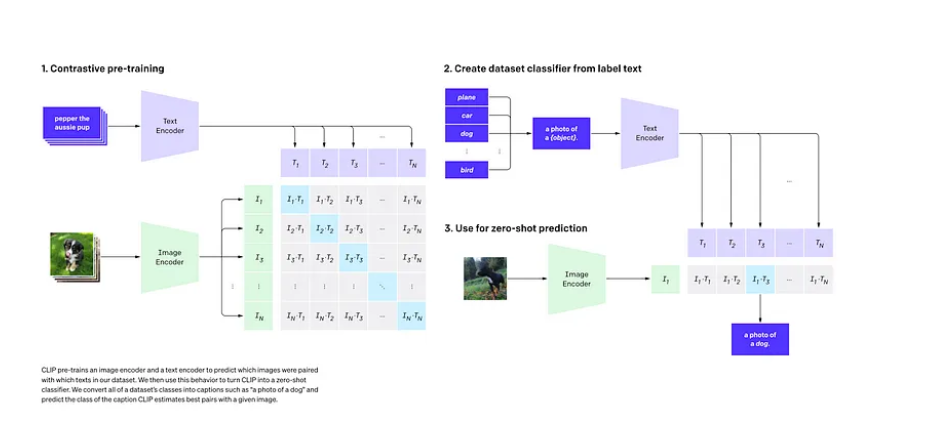

### Understanding the Role and Impact of CLIP in AI

CLIP (Contrastive Language–Image Pretraining) represents a significant breakthrough in the field of Artificial Intelligence. This innovative model has altered perceptions and set new standards, particularly in the realm of image classification.

### Response
#### Zero-Shot Classification with CLIP
- **Benchmarking Against Few-Shot Models**: CLIP's performance is particularly remarkable when contrasted with few-shot learning models. Tests against models with linear classifiers atop pre-trained backbones, such as ResNet, reveal intriguing results.

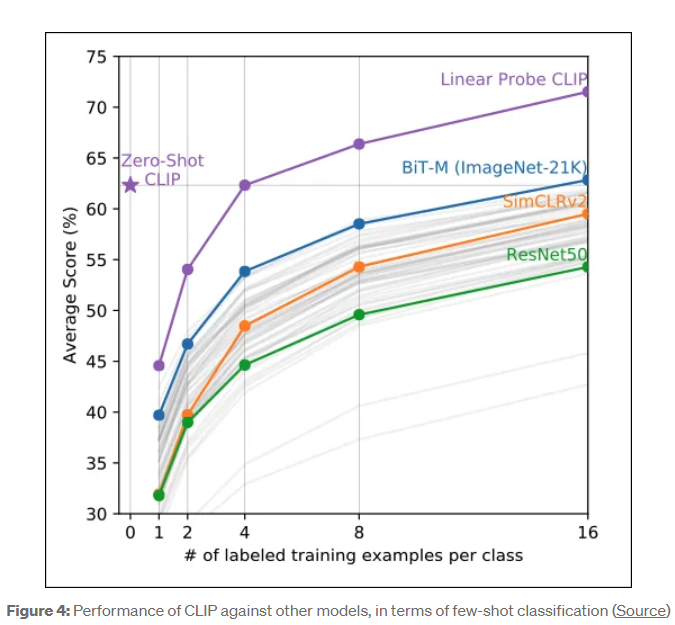

- **Equivalence with State-of-the-Art (SOTA)**: Despite being a zero-shot model, CLIP matches the accuracy of a SOTA ResNet on the ImageNet dataset. This parity is noteworthy, given the differing methodologies of the two models.
- **Robustness Across Variants**: ImageNet and its variations serve as benchmarks for distribution shift. Here, ResNet shows limitations, whereas CLIP exhibits remarkable consistency, maintaining accuracy across various versions of ImageNet.

#### Computational Efficiency
- **Shift in Focus Post-GPT-2**: Post the release of models like GPT-2, there has been a heightened focus on computational efficiency in AI model training, a shift from previous trends.
- **CLIP’s Architectural Advantage**: CLIP embodies a more computationally friendly architecture. A notable aspect of its design is the incorporation of a Vision Transformer as the primary Image Encoder, contributing to its efficiency.

In summary, CLIP stands out for its zero-shot classification prowess and computational efficiency, making it a milestone in the evolution of AI. Its ability to handle diverse image datasets with consistent accuracy and its computationally efficient architecture mark it as a significant advancement in the field.



In [2]:
import transformers
import datasets
import numpy as np
import pandas as pd
import torch
from PIL import Image
import requests

from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel

C:\Users\Divyesh Rajput\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Next, we load the CLIP model’s weights, tokenizer image processor:

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "openai/clip-vit-base-patch32"

# we initialize a tokenizer, image processor, and the model itself
tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id).to(device)

In [4]:
urls=['https://images.unsplash.com/photo-1662955676669-c5d141718bfd?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=687&q=80',
    'https://images.unsplash.com/photo-1552053831-71594a27632d?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=662&q=80',
    'https://images.unsplash.com/photo-1530281700549-e82e7bf110d6?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=688&q=80']

images=[Image.open(requests.get(i, stream=True).raw)  for i in urls]

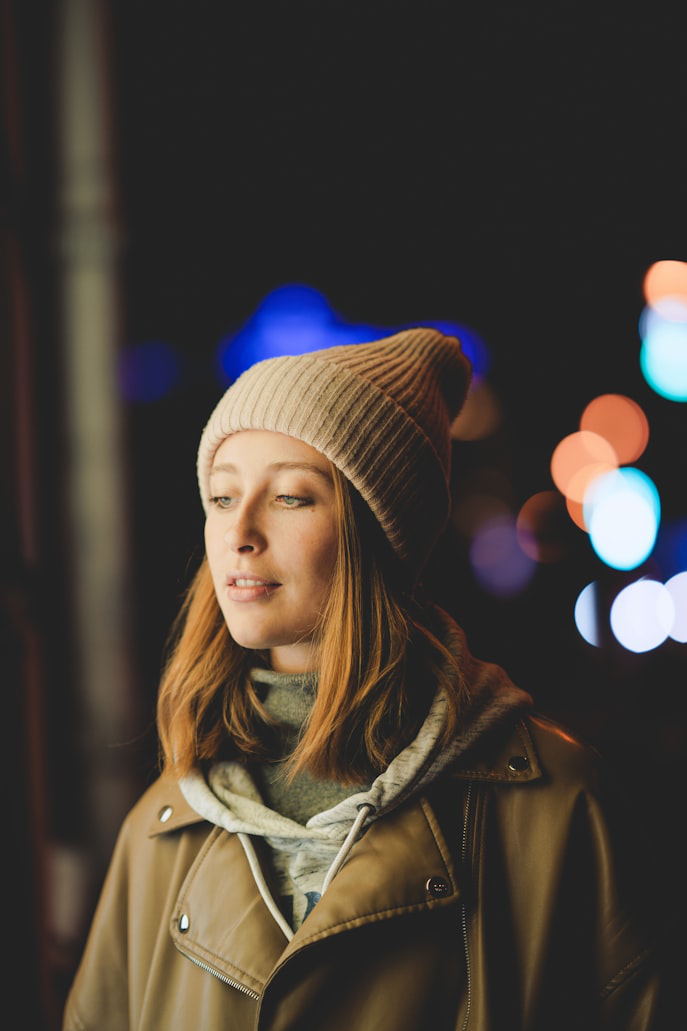

In [5]:
images[0]

Finally, we provide CLIP with some text prompts.

The goal is to let CLIP classify the 3 Unsplash images into specific text descriptions. Notice that one of them is misleading — let’s find out if we can confuse the model:

In [6]:
text_prompts=["girl wearing beanie and jacket", "a boy with a hat", "a dog", "a dog at the beach"]
inputs = inputs = processor(text=text_prompts, images=images, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image 
probs = logits_per_image.softmax(dim=1) 

In [7]:
pd.DataFrame(probs.detach().numpy()*100, columns=text_prompts, index=list(['image1','image2', 'image3'])).style.background_gradient(axis=None,low=0, high=0.91).format(precision=2)

,girl wearing beanie and jacket,a boy with a hat,a dog,a dog at the beach
image1,99.95,0.05,0.00,0.00
image2,0.05,2.82,86.11,11.02
image3,0.00,0.02,0.92,99.06


CLIP can understand multiple entities along with their actions in each image.
CLIP assigns to each image the most specific description. For instance, we can describe the second image both as ‘a dog’ and ‘a dog at the beach’. However, the model correctly decides the ‘a dog’ phrase better describes the second image because there is no beach.

## Deep Dive into Embeddings in Machine Learning and LLMs

### CONTEXT
In the realm of machine learning and Large Language Models (LLMs), embeddings play a pivotal role in transforming raw data into a format that these advanced models can understand and process. Our exploration here aims to demystify embeddings, making them accessible and comprehensible, especially to those passionate about generative AI.


#### What are Embeddings?
Embeddings are a form of representation that converts high-dimensional, sparse categorical data into lower-dimensional, dense, and continuous vectors. In simple terms, they transform abstract entities (like words or items) into a format that machine learning algorithms can work with more effectively.

#### Importance in Machine Learning and LLMs
In machine learning, particularly in natural language processing (NLP), embeddings are instrumental in capturing the semantics of language. They allow models to grasp the nuances, contexts, and relationships inherent in human language. For LLMs, embeddings serve as the foundation for understanding and generating text, enabling these models to capture and reproduce the intricacies of human language.

#### Types of Embeddings
- **Word Embeddings**: Popularized by algorithms like Word2Vec and GloVe, these embeddings capture the semantic relationships between words.
- **Sentence or Document Embeddings**: These extend the concept to larger textual units, encapsulating the meaning of sentences or entire documents.
- **Graph Embeddings**: Used in network analysis, they represent nodes and connections in a manner understandable by machine learning models.

#### Embeddings in Action
Embeddings are the underpinning of tasks like text classification, sentiment analysis, and language translation in NLP. They empower LLMs to perform complex operations like summarization, question-answering, and even creative writing.

In the dynamic landscape of AI, embeddings are not just tools but catalysts that unlock the potential of data, transforming it into a language that machines comprehend. Their role in the development and success of generative AI models is undeniable, marking them as a cornerstone of modern machine learning techniques.

---

Embark on this journey of understanding and appreciation for the power of embeddings, a key to unlocking the mysteries and capabilities of generative AI. This exploration, designed to be both educational and engaging, aims to enrich your knowledge and fuel your enthusiasm for this transformative field.


In [8]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
import torch
import numpy as np

model_id = "openai/clip-vit-base-patch32"
tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id).to("cuda" if torch.cuda.is_available() else "cpu")


In [9]:
import os
from PIL import Image

def load_and_process_images(image_folder):
    embeddings = []
    for image_name in os.listdir(image_folder):
        image_path = os.path.join(image_folder, image_name)
        image = Image.open(image_path).convert("RGB")

        # Process the image for CLIP
        inputs = processor(images=image, return_tensors="pt")

        # Generate embeddings
        with torch.no_grad():
            outputs = model.get_image_features(**inputs)

        # Store embeddings and corresponding image names
        embeddings.append((image_name, outputs.cpu().numpy()))

    return embeddings

# Replace with your image folder path
image_folder = 'D:\\Downloads March-\\sample_images_genAI'
embeddings = load_and_process_images(image_folder)


1. **Image Loading and Conversion**: The script navigates through an image folder, loading each fashion product photo using PIL (Python Imaging Library). Each image is then converted to RGB format, ensuring compatibility with the subsequent image processing steps.

2. **Processing and Embedding Generation**: Utilizing a predefined processor (`processor`), each image is prepared for embedding generation. This step involves converting the images into a tensor representation, which is a format required by the underlying neural network model (like CLIP) for processing.

3. **Embedding Extraction and Storage**: For each processed image, the script generates a unique embedding using the model while preventing any gradient updates (`torch.no_grad()`). These embeddings, representing the distinct characteristics of each fashion product photo, along with their respective image names, are compiled into a list. This list serves as a comprehensive repository of the image embeddings.


In [10]:
print(type(embeddings))

<class 'list'>


## Exploring Vector Databases with Pinecone: Creating Efficient Indices

In the landscape of vector databases, Pinecone stands out as a robust and versatile platform. The foundational element in Pinecone is the 'index', a data structure essential for the efficient searching and retrieval of vectorized data. Understanding how to effectively create and manage indices in Pinecone is key to harnessing the full potential of vector databases.


#### Constructing an Index: The First Step
To initiate, an index in Pinecone is created with a unique identifier, for example, `my_index — dr`. This identifier is crucial for referencing and managing the index in subsequent operations. 

#### Dimension and Distance Metric: Key Specifications
- **Dimension Selection**: Determining the dimension is pivotal. It represents the number of features each item in the index possesses. The choice of dimension should align with the nature and complexity of the data being indexed.
- **Distance Metric**: The essence of any vector search lies in how distances or similarities between vectors are computed. Pinecone supports various metrics like Euclidean distance, cosine similarity, and Jaccard similarity. Selecting the right distance metric is integral to achieving accurate search results.

#### Regional Deployment: Optimizing Performance
Choosing a suitable region for deploying your index is critical, especially when working with cloud-based infrastructure. With options across major cloud service providers like AWS, Google Cloud, and Azure, one can optimize for reduced latency and improved performance. For instance, selecting AWS US West 2 might be ideal if your user base or data sources are predominantly located in that region.

#### Customizing Index with Hardware Preferences
Pinecone goes a step further by allowing customization of indices to suit specific hardware requirements. This includes the creation of pod-based indices, which enhances scalability and resource efficiency. With pods, indices become more resilient and capable of accommodating larger datasets by distributing the load across multiple nodes.


In summary, the art of creating an index in Pinecone revolves around careful deliberation of dimensions, distance metrics, regional preferences, and hardware configurations. By meticulously considering these factors, one can craft a highly efficient and optimized index, setting the stage for powerful vector database applications in Pinecone.



In [11]:
from pinecone import Pinecone, PodSpec

pc = Pinecone(api_key="6e0b7ddc-cec5-4df7-b06f-78a30dde865a")
index_name = 'gen-ai-index-dr'
if index_name not in pc.list_indexes().names():
      pc.create_index(
      name="gen-ai-index-dr",
      dimension=512,
      metric="cosine",
      spec=PodSpec(
        environment="gcp-starter"
      )
    )

In [12]:
index = pc.Index("gen-ai-index-dr")

In [13]:
# Inspect the first few elements of the embeddings list
for i, (name, vec) in enumerate(embeddings[:5]):
    print(f"Element {i}:")
    print(f"Image Name: {name}, Type of name: {type(name)}")
    print(f"Embedding: {vec}, Type of embedding: {type(vec)}, Shape of embedding: {vec.shape if hasattr(vec, 'shape') else 'N/A'}")
    print()


Element 0:
Image Name: B000AOZKB0.jpg, Type of name: <class 'str'>
Embedding: [[-7.00306773e-01 -1.16798162e-01  6.92986101e-02  7.70557374e-02
  -2.92839766e-01  1.80802360e-01 -6.71368241e-02  2.53523469e-01
   5.43883443e-01  3.24961916e-02  3.63058060e-01 -4.39687192e-01
  -2.79687762e-01 -4.57603782e-01 -8.31952021e-02  3.08215618e-01
   5.29176116e-01 -2.58049667e-01 -1.56916782e-01  4.01681215e-02
  -8.83503735e-01 -3.68950635e-01  7.57721066e-02 -1.12144262e-01
   5.44987842e-02  3.42222333e-01  1.93452656e-01  4.01288271e-02
  -2.76010990e-01  5.07606119e-02  3.94614369e-01 -3.63014907e-01
   1.41189933e-01 -2.12075055e-01  5.88162988e-02 -2.46499270e-01
   5.19415140e-01  5.27042925e-01  3.73254567e-02  7.82099009e-01
  -1.09751299e-01 -2.77842760e-01  2.82445699e-02 -5.43166339e-01
   4.18725073e-01 -1.49845049e-01 -6.04019985e-02  2.98885792e-01
   2.76439309e-01 -2.81143337e-01  1.82205021e-01  2.27957740e-01
  -5.42065352e-02 -1.81781903e-01 -6.70730174e-01  3.85683179e-0

In [14]:
# Check and convert a single embedding
name, vec = embeddings[0]
print(f"Original shape of vec: {vec.shape}")
vec_flat = vec.flatten()  # Flatten the embedding
print(f"Flattened shape of vec: {vec_flat.shape}")

# Convert to list and check the first few values
vec_list = vec_flat.tolist()
print(f"First few elements of vec_list: {vec_list[:5]}")

# Prepare a single upsert entry
upsert_entry = {name: vec_list}
print(f"Upsert entry: {upsert_entry}")


Original shape of vec: (1, 512)
Flattened shape of vec: (512,)
First few elements of vec_list: [-0.70030677318573, -0.11679816246032715, 0.06929861009120941, 0.07705573737621307, -0.29283976554870605]
Upsert entry: {'B000AOZKB0.jpg': [-0.70030677318573, -0.11679816246032715, 0.06929861009120941, 0.07705573737621307, -0.29283976554870605, 0.1808023601770401, -0.06713682413101196, 0.25352346897125244, 0.5438834428787231, 0.032496191561222076, 0.36305806040763855, -0.43968719244003296, -0.279687762260437, -0.45760378241539, -0.08319520205259323, 0.3082156181335449, 0.5291761159896851, -0.2580496668815613, -0.1569167822599411, 0.040168121457099915, -0.8835037350654602, -0.36895063519477844, 0.07577210664749146, -0.11214426159858704, 0.054498784244060516, 0.34222233295440674, 0.1934526562690735, 0.04012882709503174, -0.27601099014282227, 0.05076061189174652, 0.3946143686771393, -0.36301490664482117, 0.14118993282318115, -0.21207505464553833, 0.058816298842430115, -0.24649927020072937, 0.519

In [15]:
# Create a list of tuples (id, vector) for Pinecone
upsert_list = [(name, vec.flatten().tolist()) for name, vec in embeddings]

# Try the upsert operation with this list of tuples
try:
    index.upsert(vectors=upsert_list)
    print("Upsert operation successful.")
except Exception as e:
    print(f"Upsert operation failed: {e}")


Upsert operation successful.


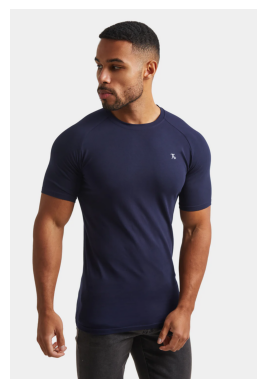

Shape of embeddings: torch.Size([1, 512])


In [16]:
import matplotlib.pyplot as plt

def process_and_display_image(query_image_path, processor, model):
    # Load and display the query image
    query_image = Image.open(query_image_path).convert("RGB")
    plt.imshow(query_image)
    plt.axis('off')
    plt.show()

    # Process the image and generate embeddings
    inputs = processor(images=query_image, return_tensors="pt")
    with torch.no_grad():
        query_embedding = model.get_image_features(**inputs)
    
    # Print the shape of the embeddings
    print(f"Shape of embeddings: {query_embedding.shape}")

    # Return the embedding for further checks
    return query_embedding

# Example usage
query_image_path = 'D:\\Downloads March-\\search_image\\abc.jpg'
embedding = process_and_display_image(query_image_path, processor, model)


In [17]:
def process_image_for_query(query_image_path, processor, model):
    # Load the query image
    query_image = Image.open(query_image_path).convert("RGB")

    # Process the image and generate embeddings
    inputs = processor(images=query_image, return_tensors="pt")
    with torch.no_grad():
        query_embedding = model.get_image_features(**inputs)

    # Convert the embedding to a list
    query_embedding_list = query_embedding.squeeze().cpu().tolist()

    # Return the embedding list for the query
    return query_embedding_list

# Example usage
query_image_path = 'D:\\Downloads March-\\search_image\\abc.jpg'
embedding_list = process_image_for_query(query_image_path, processor, model)

### Calculating Similarity

The similarity in CLIP embeddings is expressed via their angular similarity, which means we can determine similar pairs using cosine similarity:


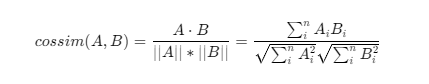

### Querying the index

The `index.query` function in Pinecone is a powerful tool for querying vector indices. Central to this function are its parameters, which dictate how queries are processed and results are returned. Key parameters include the query vector (`query_vectors`), which represents the vector or set of vectors to search against the index. The `top_k` parameter specifies the number of nearest vectors to return, essentially determining the breadth of the search result. Additionally, `include_values`, when set to `True`, returns the actual vectors along with their metadata, providing richer context to the query results. Users can also filter results using the `filter` parameter to apply specific criteria, enhancing the precision of the search. The `index.query` function's flexibility and customization capabilities make it an essential aspect of efficiently retrieving and analyzing relevant data from a vector database in Pinecone.


In [18]:
results = index.query(
  vector=embedding_list,
  top_k=3,
  include_values=True
)

In [19]:
# Get the ID of the top result
top_result_id = results["matches"][0]["id"]

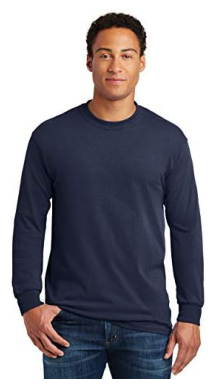

In [20]:
def display_image_from_id(image_id, image_folder):
    # Construct the path to the image
    image_path = os.path.join(image_folder, image_id)

    # Load and display the image
    try:
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    except FileNotFoundError:
        print(f"Image not found: {image_path}")

def display_top_result_image(results, image_folder):
    if not results or "matches" not in results:
        print("No results to display.")
        return

    # Get the ID of the top result
    top_result_id = results["matches"][0]["id"]
#     top_result_id_2 = results["matches"][1]["id"]
    # Display the image corresponding to this ID
    display_image_from_id(top_result_id, image_folder)
#     display_image_from_id(top_result_id_2, image_folder)

# Example usage
image_folder = 'D:\\Downloads March-\\sample_images_genAI'
results = display_top_result_image(results, image_folder)

The above execution demonstrates a practical application of our script, where we uploaded an image of a navy blue half-sleeves t-shirt. The script initially transformed the uploaded image into embeddings, a process critical for enabling the similarity search within the Pinecone database. Subsequently, it performed a search across our extensive product catalog stored in Pinecone. The result of this query was the identification and retrieval of the most closely related item from the catalog - a full-sleeves navy blue t-shirt. This outcome exemplifies the script's capability to accurately process and match products based on visual similarity, underscoring the efficacy of embedding-based searches in vector databases.

## One-shot Text-based Search

### Image Retrieval

**How do we do retrieval?**

We encode a search query (e.g., "black gloves") with CLIP text encoder and retrieve the closest image vectors through a simple dot product. The greater the value of the dot product, the more similar the text and the image are.

In [21]:
import numpy as np
def generate_text_embedding(text, processor, model):
    # Process the text input
    inputs = processor(text=text, return_tensors="pt")

    # Generate the embedding
    with torch.no_grad():
        text_embedding = model.get_text_features(**inputs)
    
    # Normalize the text embedding
    text_embedding = text_embedding.cpu().numpy().flatten()
    text_embedding /= np.linalg.norm(text_embedding, 2)

    # Ensure all values are finite
    if not np.isfinite(text_embedding).all():
        raise ValueError("Text embedding contains non-finite values")

    return text_embedding.tolist()



In [22]:
def generate_text_embedding(text, processor, model):
    # Process the text input
    inputs = processor(text=text, return_tensors="pt")

    # Generate the embedding
    with torch.no_grad():
        text_embedding = model.get_text_features(**inputs)
    
    # Normalize the text embedding
    text_embedding = text_embedding.cpu().numpy().flatten()
    text_embedding /= np.linalg.norm(text_embedding, 2)

    # Ensure all values are finite
    if not np.isfinite(text_embedding).all():
        raise ValueError("Text embedding contains non-finite values")

    # Print length and first few values of the embedding for inspection
    print(f"Length of embedding: {len(text_embedding)}")
    print(f"First few values of embedding: {text_embedding[:5]}")

    return text_embedding.tolist()

# Test with a simple text
test_text = "black gloves"
test_embedding = generate_text_embedding(test_text, processor, model)

Length of embedding: 512
First few values of embedding: [ 0.01561103  0.0173941  -0.07070592 -0.01974448  0.0111077 ]


Text Preprocessing and Embedding Generation: The function takes a text input, processes it using the CLIP model's processor for tokenization and other preprocessing, and then generates a high-dimensional embedding vector representing the textual information.

Normalization and Validation: The embedding is normalized to have a unit length (L2 normalization), ensuring consistency in magnitude, which is crucial for accurate similarity comparisons. The function also checks for any non-finite values (like NaN or Infinity) to ensure the embedding's numerical stability.

Debugging Information: It prints the length and a few sample values of the generated embedding, assisting in verifying the output's correctness and understanding the nature of the embeddings.

Versatile Output: The output is a normalized, 1D list of numerical values, compatible with various vector-based search applications and databases like Pinecone, making it versatile for different use cases involving text-based similarity searches.

This function essentially transforms textual data into a quantifiable format that machines can interpret, compare, and utilize in various machine learning and data retrieval applications.

In [23]:
text_search_results = index.query(
  vector=test_embedding,
  top_k=2,
  include_values=True
)

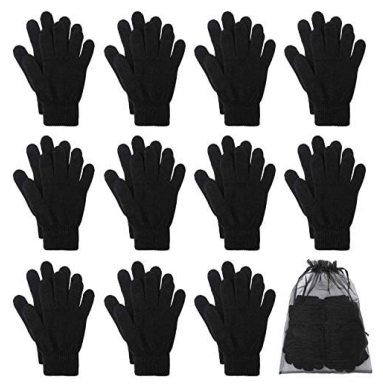

In [24]:
results = display_top_result_image(text_search_results, image_folder)

## Future Scope of CLIP-based Image Similarity in Online Shopping

Building upon the successful implementation of CLIP for fashion product image analysis in our proof of concept, there is significant potential for expanding this technology in the realm of online shopping and beyond. Here are key areas where this innovative approach can be further developed:

- **Enhanced Personalized Shopping Experience**: By integrating CLIP-powered image analysis with user behavior data, online shopping platforms can offer highly personalized recommendations. For instance, a customer browsing for a specific style of clothing could receive suggestions not just based on textual descriptions, but also on visual similarities to items they've shown interest in, thereby refining the shopping experience to align more closely with individual preferences.

- **Seamless Cross-Platform Integration**: This technology could be expanded to work across various online platforms. Users could upload images of fashion items they like on one platform, and the system could find similar items available on different e-commerce websites. This cross-platform capability would significantly enhance the convenience and scope of online shopping.

- **Real-Time Visual Search in Physical Retail**: Extending the technology to physical retail stores through smartphone apps could revolutionize the shopping experience. Shoppers could take photos of items in a store and instantly receive information on similar products available in the same store or even compare prices and styles with other local or online retailers. This application could merge the convenience of online shopping with the tangibility of in-store browsing.

By leveraging the prowess of CLIP in understanding and analyzing visual content, these advancements could greatly enhance both online and offline shopping experiences, making them more intuitive, personalized, and interconnected.


## References

https://www.pinecone.io/learn/series/image-search/clip/

https://github.com/openai/CLIP

https://levelup.gitconnected.com/introducing-gans-with-keras-pythons-powerful-generative-ai-framework-3ecbb27bddd1

https://medium.com/@paluchasz/understanding-openais-clip-model-6b52bade3fa3

***
MIT License

Copyright (c) 2024 Divyesh Singh Rajput

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.